**IMPORT LIBRARIES**

In [2]:
import nibabel as nb
import matplotlib.pyplot as plt
import numpy as np
import sys
import glob
from tqdm import tqdm
from skimage.transform import resize
from sklearn.model_selection import train_test_split
import cv2
from skimage.transform import resize

**MOUNT GOOGLE DRIVE**

In [3]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Changing the directory
%cd '/content/drive/MyDrive/DSGP_Ravisha'

/content/drive/MyDrive/DSGP_Ravisha


**DATASET PREPARATION AND SPLITING**

In [12]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define target data path (Update this to your actual dataset location)
target_data_path = "/content/drive/MyDrive/DSGP_Ravisha"  # Modify based on your directory structure

# Define paths
image_dir = os.path.join(target_data_path, "sattelite images")  # Satellite images
mask_dir = os.path.join(target_data_path, "Weligama_EPR")  # Binary EPR masks

train_dir = os.path.join(target_data_path, "training")
val_dir = os.path.join(target_data_path, "validation")
test_dir = os.path.join(target_data_path, "testing")

# Create directories for training, validation, and testing sets
for d in [train_dir, val_dir, test_dir]:
    os.makedirs(os.path.join(d, "images"), exist_ok=True)
    os.makedirs(os.path.join(d, "masks"), exist_ok=True)

# Get all image filenames (ignoring path)
image_filenames = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg')])

# Ensure masks exist for each image (based on base name, with ' copy.png' extension)
valid_images = []
for image_file in image_filenames:
    base_name = os.path.splitext(image_file)[0]  # Get the base name without extension
    mask_file = f"{base_name} copy.png"  # Construct corresponding mask filename
    if os.path.exists(os.path.join(mask_dir, mask_file)):
        valid_images.append(image_file)

print(f"Total valid image-mask pairs found: {len(valid_images)}")

# Split dataset (70% train, 15% val, 15% test)
train_files, test_files = train_test_split(valid_images, test_size=0.30, random_state=42)
val_files, test_files = train_test_split(test_files, test_size=0.50, random_state=42)  # 15% each

# Function to move files
def move_files(file_list, src_img, src_mask, dest):
    for f in file_list:
        mask_filename = os.path.splitext(f)[0] + ' copy.png'  # Construct corresponding mask filename
        shutil.copy(os.path.join(src_img, f), os.path.join(dest, "images", f))
        shutil.copy(os.path.join(src_mask, mask_filename), os.path.join(dest, "masks", mask_filename))

# Move files to respective folders
move_files(train_files, image_dir, mask_dir, train_dir)
move_files(val_files, image_dir, mask_dir, val_dir)
move_files(test_files, image_dir, mask_dir, test_dir)

print("Dataset successfully split into Training, Validation, and Testing sets!")


Total valid image-mask pairs found: 74
Dataset successfully split into Training, Validation, and Testing sets!


**IMAGE AND SEGMENTATION MASK VISUALIZATION**

In [13]:
# Plot image and its corresponding segmentation mask
def plot_images(img, mask):
    if img is None or mask is None:
        print("Error: One or both files could not be loaded.")
        return

    print("img shape:", img.shape)
    print("mask shape:", mask.shape)
    print("mask min:", mask.min())
    print("mask max:", mask.max())
    print("mask unique values:", np.unique(mask))

    viz_dict = {"Image": img, "Segmentation Map": mask}

    fig = plt.figure(figsize=(15, 15))

    count = 2
    for i, j in viz_dict.items():
        ax = plt.subplot(1, 3, count)
        plt.imshow(j, cmap='gray')
        plt.title(i)
        plt.axis("on")
        count += 1


def plot_images_by_path(image_path, mask_path):
    # Check if files exist
    if not os.path.exists(image_path):
        print(f"Error: Image file not found at {image_path}")
        return

    if not os.path.exists(mask_path):
        print(f"Error: Mask file not found at {mask_path}")
        return

    img = cv2.imread(image_path)  # Load the image in color (BGR format)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Load the mask in grayscale (binary)

    plot_images(img, mask)


def plot_images_after_cleaning(img,mask):

  print("img " , img.shape)
  print("mask ", mask.shape)
  print("mask min ", mask.min())
  print("mask max ", mask.max())
  print("mask unique values ", np.unique(mask))

  viz_dict = {"Image": img[:,:,0], "Segmentation Map": mask}
  fig = plt.figure(figsize=(15, 15))

  count = 2

  for i, j in viz_dict.items():
    ax = plt.subplot(1, 3, count)
    plt.imshow(j)
    plt.colorbar()
    plt.title(i)
    plt.axis("on")
    count += 1

img shape: (1735, 1146, 3)
mask shape: (1735, 1146)
mask min: 0
mask max: 255
mask unique values: [  0 255]


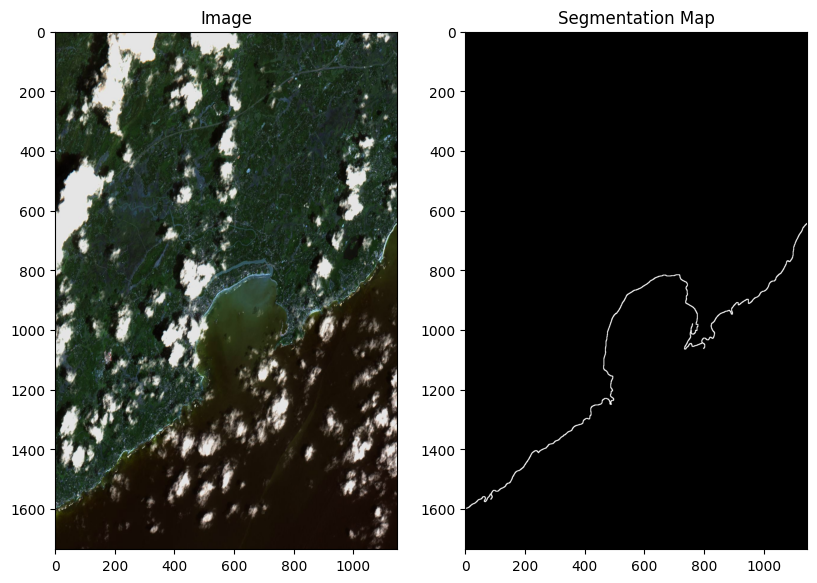

In [14]:
image_path = 'training/images/sentinel2_void_2023-11-18_Weligama.jpg'
mask_path =  'training/masks/sentinel2_void_2023-11-18_Weligama copy.png'

plot_images_by_path(image_path, mask_path)

**IMAGE AND MASK SELECTION & LOADING**

In [15]:
# Function to select image and mask files
def select_data(env, datatype_annotation):
    file_input = f'target/{env}/*/*{datatype_annotation}*'
    return sorted(glob.glob(file_input))

# Function to load images and masks
def load_data(image_filenames, mask_filenames):
    images = []
    masks = []

    # Load images
    for file_name in tqdm(image_filenames):
        img = cv2.imread(file_name)  # Read image in color (BGR)
        if img is None:
            print(f"Error: Unable to load {file_name}")
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        images.append(img)

    # Load masks
    for file_name in tqdm(mask_filenames):
        mask = cv2.imread(file_name, cv2.IMREAD_GRAYSCALE)  # Read in grayscale
        if mask is None:
            print(f"Error: Unable to load {file_name}")
            continue
        masks.append(mask)

    return images, masks


**IMAGE AND MASK PROCESSING WITH CROPPING & LOADING**

In [16]:
import cv2
import glob
import numpy as np
from PIL import Image
from tqdm import tqdm

# Function to select image and mask files
def select_data(env, datatype_annotation):
    file_input = f'target/{env}/*/*{datatype_annotation}*'
    return sorted(glob.glob(file_input))

# Function to crop image to a square from the center
def crop_to_square(image):
    height, width = image.shape[:2]  # Get image dimensions
    min_dim = min(height, width)  # Find the shortest side

    # Calculate center crop box
    left = (width - min_dim) // 2
    top = (height - min_dim) // 2
    right = left + min_dim
    bottom = top + min_dim

    return image[top:bottom, left:right]  # Crop and return

# Function to load images and masks with cropping & resizing
def load_data(image_filenames, mask_filenames):
    images = []
    masks = []

    # Load images
    for file_name in tqdm(image_filenames):
        img = cv2.imread(file_name)  # Read image in color (BGR)
        if img is None:
            print(f"Error: Unable to load {file_name}")
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        img = crop_to_square(img)
        images.append(img)

    # Load masks
    for file_name in tqdm(mask_filenames):
        mask = cv2.imread(file_name, cv2.IMREAD_GRAYSCALE)  # Read in grayscale
        if mask is None:
            print(f"Error: Unable to load {file_name}")
            continue
        mask = crop_to_square(mask)
        masks.append(mask)

    return images, masks

**IMAGE AND MASK SELECTION WITH VALIDATION**

In [19]:
from tqdm import tqdm
import os

# Function to select the image and mask files based on directory and extension
def select_data(data_type, extension):
    # For images, the extension will be '.jpg'
    if extension == '.jpg':
        image_dir = os.path.join(target_data_path, data_type, "images")
        # Use tqdm to show progress while selecting files
        return sorted([f for f in tqdm(os.listdir(image_dir), desc=f"Loading {data_type} images") if f.endswith(extension)])

    # For masks, the extension will be '.png', specifically ' copy.png' for your case
    elif extension == '.png':
        mask_dir = os.path.join(target_data_path, data_type, "masks")
        # Use tqdm to show progress while selecting files
        return sorted([f for f in tqdm(os.listdir(mask_dir), desc=f"Loading {data_type} masks") if f.endswith(' copy.png')])

# Select files for training images and masks
training_image_files = select_data('training', '.jpg')
training_mask_files = select_data('training', '.png')

# Ensure the number of images and masks match
valid_image_mask_pairs = [
    image for image in training_image_files
    if os.path.exists(os.path.join(target_data_path, 'training', 'masks', f"{os.path.splitext(image)[0]} copy.png"))
]

# Print sample information
print(f"\nTraining images: {len(valid_image_mask_pairs)}")
print(f"Training masks: {len(valid_image_mask_pairs)}")

# Load training images and masks (adjusted to match the files)
training_images = [os.path.join(target_data_path, 'training', 'images', f) for f in valid_image_mask_pairs]
training_masks = [os.path.join(target_data_path, 'training', 'masks', f"{os.path.splitext(f)[0]} copy.png") for f in valid_image_mask_pairs]

# Print loaded data
print(f"Loaded {len(training_images)} images and {len(training_masks)} masks.")


Loading training masks: 100%|██████████| 51/51 [00:00<00:00, 420254.43it/s]


Training images: 51
Training masks: 51
Loaded 51 images and 51 masks.


**TESTING IMAGE AND MASK SELECTION WITH VALIDATION**

In [21]:
# Select files for testing images and masks
testing_image_files = select_data('testing', '.jpg')
testing_mask_files = select_data('testing', '.png')

# Ensure the number of images and masks match
valid_testing_image_mask_pairs = [
    image for image in testing_image_files
    if os.path.exists(os.path.join(target_data_path, 'testing', 'masks', f"{os.path.splitext(image)[0]} copy.png"))
]

# Print sample information
print(f"\nTesting images: {len(valid_testing_image_mask_pairs)}")
print(f"Testing masks: {len(valid_testing_image_mask_pairs)}")

# Load testing images and masks (adjusted to match the valid pairs)
testing_images = [os.path.join(target_data_path, 'testing', 'images', f) for f in valid_testing_image_mask_pairs]
testing_masks = [os.path.join(target_data_path, 'testing', 'masks', f"{os.path.splitext(f)[0]} copy.png") for f in valid_testing_image_mask_pairs]

# Print loaded data
print(f"Loaded {len(testing_images)} testing images and {len(testing_masks)} masks.")


Loading testing masks: 100%|██████████| 12/12 [00:00<00:00, 148034.26it/s]


Testing images: 12
Testing masks: 12
Loaded 12 testing images and 12 masks.


**VALIDATION IMAGE AND MASK SELECTION WITH VALIDATION**

In [23]:
# Select files for validation images and masks
validation_image_files = select_data('validation', '.jpg')
validation_mask_files = select_data('validation', '.png')

# Ensure the number of images and masks match for validation
valid_validation_image_mask_pairs = [
    image for image in validation_image_files
    if os.path.exists(os.path.join(target_data_path, 'validation', 'masks', f"{os.path.splitext(image)[0]} copy.png"))
]

# Print sample information
print(f"\nValidation images: {len(valid_validation_image_mask_pairs)}")
print(f"Validation masks: {len(valid_validation_image_mask_pairs)}")

# Load validation images and masks (adjusted to match valid pairs)
validation_images = [os.path.join(target_data_path, 'validation', 'images', f) for f in valid_validation_image_mask_pairs]
validation_masks = [os.path.join(target_data_path, 'validation', 'masks', f"{os.path.splitext(f)[0]} copy.png") for f in valid_validation_image_mask_pairs]

# Print loaded data
print(f"Loaded {len(validation_images)} validation images and {len(validation_masks)} masks.")


Loading validation masks: 100%|██████████| 11/11 [00:00<00:00, 146467.76it/s]


Validation images: 11
Validation masks: 11
Loaded 11 validation images and 11 masks.


**IMAGE AND MASK RESIZING FUNCTION**

In [24]:
from skimage.transform import resize

def resize_images(images_raw, masks_raw,target_size=(512, 512)):
  images = []
  masks = []

  for img, msk in zip(images_raw, masks_raw):
    # Resize to 200x200
    img = cv2.resize(img, target_size, interpolation=cv2.INTER_LINEAR)  # Resize to target size
    msk = cv2.resize(msk, target_size, interpolation=cv2.INTER_NEAREST)  # Resize masks using NEAREST interpolation

    images.append(img)
    masks.append(msk)


  return images, masks;

**IMAGE AND MASK RESIZING FUNCTION WITH DATA PROCESSING**

In [26]:
import cv2
import numpy as np

# Function to resize images and masks
def resize_images(image_list, mask_list, target_size=(540, 540)):
    resized_images = []
    resized_masks = []

    for image_path, mask_path in zip(image_list, mask_list):
        # Read the image and mask
        image = cv2.imread(image_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Ensure mask is loaded as grayscale

        # Resize the image and mask
        resized_image = cv2.resize(image, target_size, interpolation=cv2.INTER_LINEAR)
        resized_mask = cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST)  # Use nearest neighbor for masks

        resized_images.append(resized_image)
        resized_masks.append(resized_mask)

    return np.array(resized_images), np.array(resized_masks)

# Train data resize
training_images, training_masks = resize_images(training_images, training_masks)

# Testing data resize
testing_images, testing_masks = resize_images(testing_images, testing_masks)

# Validation data resize
validation_images, validation_masks = resize_images(validation_images, validation_masks)


In [27]:
print(f"Validation images count: {len(validation_images)}")
print(f"Validation masks count: {len(validation_masks)}")


Validation images count: 11
Validation masks count: 11


img  (540, 540, 3)
mask  (540, 540)
mask min  0
mask max  255
mask unique values  [  0 255]


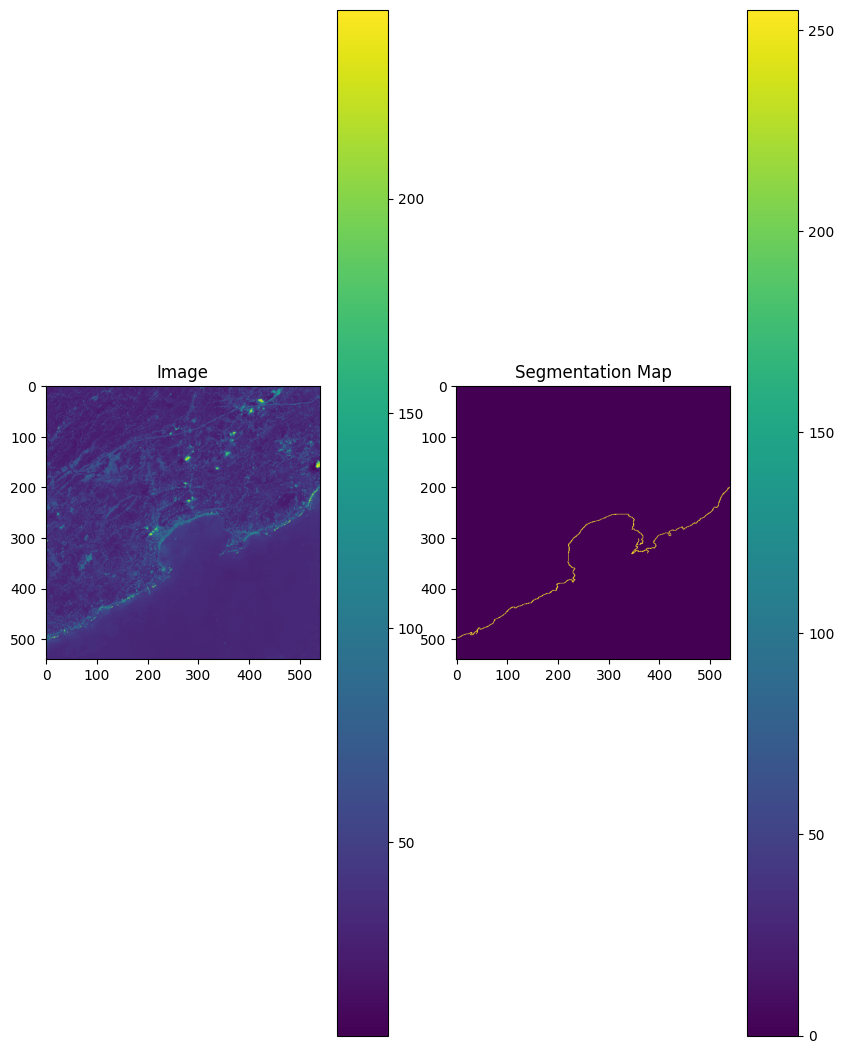

In [28]:
plot_images_after_cleaning(validation_images[0], validation_masks[0])

**CREATE DIRECTORIES FOR NUMPY DATA STORAGE**

In [29]:
!mkdir -p 'target/training/numpy'
!mkdir -p 'target/testing/numpy'
!mkdir -p 'target/validation/numpy'

**SAVE RESIZED IMAGES AND MASKS AS NUMPY ARRAYS**

In [30]:
np.save('target/training/numpy/images.npy', training_images)
np.save('target/training/numpy/masks.npy', training_masks)

**SAVE TESTING IMAGES AND MASKS AS NUMPY ARRAYS**

In [31]:
np.save('target/testing/numpy/images.npy', testing_images)
np.save('target/testing/numpy/masks.npy', testing_masks)

**SAVE VALIDATION IMAGES AND MASKS AS NUMPY ARRAYS**

In [32]:
np.save('target/validation/numpy/images.npy', validation_images)
np.save('target/validation/numpy/masks.npy', validation_masks)

img shape: (540, 540, 3)
mask shape: (540, 540)
mask min: 0
mask max: 255
mask unique values: [  0 255]


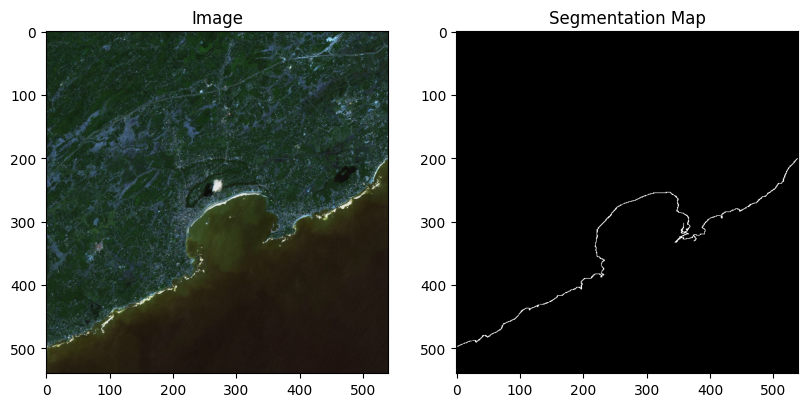

In [33]:
plot_images(training_images[0],training_masks[0])


In [34]:
import os

# Example for checking file existence
file_path = 'target/training/numpy/images.npy'
if os.path.exists(file_path):
    print("File found:", file_path)
else:
    print("File not found.")


File found: target/training/numpy/images.npy
